In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import  matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, Activation, Flatten,BatchNormalization,Input, Conv1D, MaxPooling1D,LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
import joblib
import seaborn as sns
from sklearn.decomposition import PCA
import time

2025-04-19 08:31:26.706764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745051486.899820      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745051486.953722      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_parquet('/kaggle/input/cicids2018/merged10-4.parquet')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8247888 entries, 0 to 8247887
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float32
 1   Protocol           int8   
 2   Timestamp          int32  
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int32  
 5   Tot Bwd Pkts       int32  
 6   TotLen Fwd Pkts    int64  
 7   TotLen Bwd Pkts    int64  
 8   Fwd Pkt Len Max    int32  
 9   Fwd Pkt Len Min    int32  
 10  Fwd Pkt Len Mean   float32
 11  Fwd Pkt Len Std    float32
 12  Bwd Pkt Len Max    int32  
 13  Bwd Pkt Len Min    int32  
 14  Bwd Pkt Len Mean   float32
 15  Bwd Pkt Len Std    float32
 16  Flow Byts/s        float32
 17  Flow Pkts/s        float32
 18  Flow IAT Mean      float32
 19  Flow IAT Std       float32
 20  Flow IAT Max       int64  
 21  Flow IAT Min       int64  
 22  Fwd IAT Tot        int64  
 23  Fwd IAT Mean       float32
 24  Fwd IAT Std        float32
 25  Fwd IAT Max       

In [8]:
class_dict ={'Benign': 0,'DDOS attack-HOIC': 4,'DoS attacks-Hulk': 7,'Bot': 1,'FTP-BruteForce': 10,'SSH-Bruteforce': 13,'Infilteration': 11,'DoS attacks-SlowHTTPTest': 8,'DoS attacks-GoldenEye': 6,'DoS attacks-Slowloris': 9,'DDOS attack-LOIC-UDP': 5,'Brute Force -Web': 2,'Brute Force -XSS': 3,'SQL Injection': 12}
label_counts = data['Label'].value_counts()
inverse_class_dict = {v: k for k, v in class_dict.items()}
max_name_length = max(len(name) for name in inverse_class_dict.values())
padding_width = max_name_length + 5
print(f"{'Attack ':<{padding_width}} Count")
print("-" * (padding_width + len("Count") + 1))
for label_code, count in label_counts.items():
    attack_name = inverse_class_dict.get(label_code, f"Unknown Label ({label_code})")
    print(f"{attack_name:<{padding_width}} {count}")

Attack                        Count
-----------------------------------
Benign                        6077145
DDOS attack-HOIC              686012
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193354
SSH-Bruteforce                187589
Infilteration                 160639
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP          1730
Brute Force -Web              611
Brute Force -XSS              230
SQL Injection                 87


In [11]:
X = data.drop('Label', axis=1)
y = data['Label']
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
del X,y

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6598310, 79, 1), (1649578, 79, 1), (6598310,), (1649578,))

# LSTM without PCA

In [13]:
lstm = Sequential()
lstm.add(LSTM(units=192,activation='tanh',return_sequences=True,input_shape=(X_train.shape[1], 1)))
lstm.add(LSTM(units=125,activation='tanh',return_sequences=False)) 
lstm.add(Dense(128, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(14, activation='softmax'))
lstm.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0),metrics=['accuracy'])
lstm.summary()

I0000 00:00:1745040747.548294      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 79, 192)             │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 125)                 │         159,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 325,926 (1.24 MB)

 Trainable params: 325,926 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
 hist_lstm=lstm.fit(X_train, y_train, epochs=10, batch_size=512,validation_data=(X_test,y_test)) 

Epoch 1/10


I0000 00:00:1745040758.745942     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


12888/12888 ━━━━━━━━━━━━━━━━━━━━ 477s 37ms/step - accuracy: 0.9322 - loss: 0.2402 - val_accuracy: 0.9554 - val_loss: 0.1790
Epoch 2/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 474s 37ms/step - accuracy: 0.9808 - loss: 0.0564 - val_accuracy: 0.9824 - val_loss: 0.0518
Epoch 3/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 474s 37ms/step - accuracy: 0.9823 - loss: 0.0486 - val_accuracy: 0.9821 - val_loss: 0.0454
Epoch 4/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 475s 37ms/step - accuracy: 0.9824 - loss: 0.0449 - val_accuracy: 0.9841 - val_loss: 0.0411
Epoch 5/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 469s 36ms/step - accuracy: 0.9839 - loss: 0.0386 - val_accuracy: 0.9838 - val_loss: 0.0363
Epoch 6/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 468s 36ms/step - accuracy: 0.9851 - loss: 0.0346 - val_accuracy: 0.9854 - val_loss: 0.0317
Epoch 7/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 472s 37ms/step - accuracy: 0.9857 - loss: 0.0314 - val_accuracy: 0.9865 - val_loss: 0.0278
Epoch 8/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 471s 37ms/step - accur

In [17]:
start_time = time.perf_counter()
y_pred = lstm.predict(X_test)
end_time = time.perf_counter()

51550/51550 ━━━━━━━━━━━━━━━━━━━━ 192s 4ms/step


In [18]:
duration = end_time - start_time
print(f"Time taken for LSTM without PCA : {duration:.6f} seconds")

Time taken for LSTM without PCA : 228.181160 seconds


In [19]:
y_pred = np.argmax(y_pred, axis=1)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted',zero_division=0)
precision = precision_score(y_test, y_pred, average='weighted',zero_division=0)
print(f"Accuracy: {accuracy:.6f}")
print(f"Weighted Recall: {recall:.6f}")
print(f"Weighted Precision: {precision:.6f}")

Accuracy: 0.986546
Weighted Recall: 0.986546
Weighted Precision: 0.984871


# LSTM with PCA for n_components = 15

In [3]:
X = data.drop('Label', axis=1)
y = data['Label']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [4]:
pca = PCA(n_components=15,random_state=42)
X_pca = pca.fit_transform(X)
del X

PCA with 15 components
Total Explained Variance: 0.9966


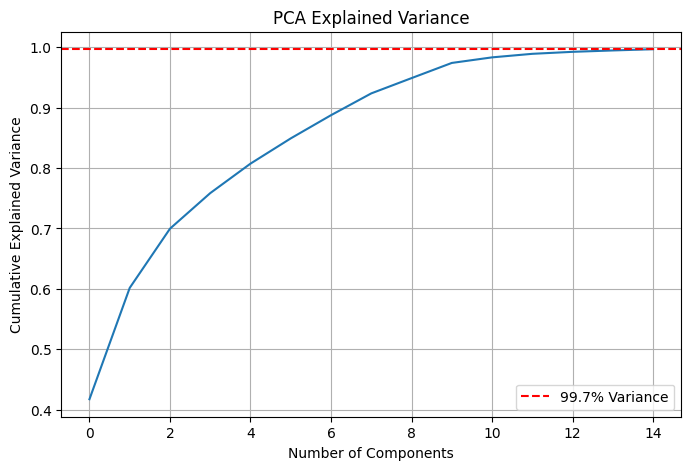

In [5]:
print(f"PCA with {pca.n_components_} components")
print(f"Total Explained Variance: {np.sum(pca.explained_variance_ratio_):.4f}")

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.axhline(y=np.sum(pca.explained_variance_ratio_), color='r', linestyle='--', label=f'{np.sum(pca.explained_variance_ratio_)*100:.1f}% Variance')
plt.legend(loc='best')
plt.show()

In [6]:
explained_variance_ratio = pca.explained_variance_ratio_
components = pca.components_
feature_names=data.drop("Label",axis=1).columns
print("PCA Components and Explained Variance (Concise List):")
for i in range(pca.n_components_):
    pc_name = f"PC{i+1}"
    variance_ratio = explained_variance_ratio[i]
    loadings = components[i]
    feature_loadings = pd.Series(loadings, index=feature_names)
    top_features = feature_loadings.abs().sort_values(ascending=False).head(3) # Top 3 features

    top_feature_names = top_features.index.tolist()
    top_feature_loadings_values = feature_loadings[top_feature_names].tolist()

    print(f"\n{pc_name}: Explained Variance Ratio = {variance_ratio:.4f}")
    for j in range(len(top_feature_names)):
        print(f"  - Top Feature {j+1}: {top_feature_names[j]} ( {top_feature_loadings_values[j]:.2f} )")

PCA Components and Explained Variance (Concise List):

PC1: Explained Variance Ratio = 0.4173
  - Top Feature 1: PSH Flag Cnt ( 0.59 )
  - Top Feature 2: ACK Flag Cnt ( -0.49 )
  - Top Feature 3: RST Flag Cnt ( 0.40 )

PC2: Explained Variance Ratio = 0.1843
  - Top Feature 1: ACK Flag Cnt ( 0.62 )
  - Top Feature 2: Dst Port ( 0.40 )
  - Top Feature 3: Protocol ( -0.36 )

PC3: Explained Variance Ratio = 0.0980
  - Top Feature 1: PSH Flag Cnt ( 0.58 )
  - Top Feature 2: Protocol ( -0.46 )
  - Top Feature 3: ECE Flag Cnt ( -0.37 )

PC4: Explained Variance Ratio = 0.0589
  - Top Feature 1: Init Fwd Win Byts ( 0.68 )
  - Top Feature 2: Dst Port ( 0.44 )
  - Top Feature 3: Init Bwd Win Byts ( -0.32 )

PC5: Explained Variance Ratio = 0.0488
  - Top Feature 1: Dst Port ( 0.68 )
  - Top Feature 2: Init Fwd Win Byts ( -0.44 )
  - Top Feature 3: URG Flag Cnt ( 0.37 )

PC6: Explained Variance Ratio = 0.0418
  - Top Feature 1: SYN Flag Cnt ( 0.57 )
  - Top Feature 2: Fwd PSH Flags ( 0.57 )
  - Top

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6598310, 15, 1), (1649578, 15, 1), (6598310,), (1649578,))

In [10]:
lstm_pca = Sequential()
lstm_pca.add(LSTM(units=192,activation='tanh',return_sequences=True,input_shape=(X_train.shape[1], 1)))
lstm_pca.add(LSTM(units=125,activation='tanh',return_sequences=False)) 
lstm_pca.add(Dense(128, activation='relu'))
lstm_pca.add(Dropout(0.2))
lstm_pca.add(Dense(14, activation='softmax'))
lstm_pca.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0),metrics=['accuracy'])
lstm_pca.summary()

I0000 00:00:1745051563.658793      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 192)             │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 125)                 │         159,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 325,926 (1.24 MB)

 Trainable params: 325,926 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
hist_lstm_pca=lstm_pca.fit(X_train, y_train, epochs=10, batch_size=512,validation_data=(X_test,y_test)) 

Epoch 1/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 467s 36ms/step - accuracy: 0.9804 - loss: 0.0651 - val_accuracy: 0.9813 - val_loss: 0.0540
Epoch 2/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 478s 37ms/step - accuracy: 0.9818 - loss: 0.0517 - val_accuracy: 0.9822 - val_loss: 0.0460
Epoch 3/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 477s 37ms/step - accuracy: 0.9823 - loss: 0.0474 - val_accuracy: 0.9813 - val_loss: 0.0433
Epoch 4/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 473s 37ms/step - accuracy: 0.9837 - loss: 0.0385 - val_accuracy: 0.9842 - val_loss: 0.0365
Epoch 5/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 470s 36ms/step - accuracy: 0.9854 - loss: 0.0331 - val_accuracy: 0.9836 - val_loss: 0.0336
Epoch 6/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 475s 37ms/step - accuracy: 0.9859 - loss: 0.0311 - val_accuracy: 0.9854 - val_loss: 0.0313
Epoch 7/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 474s 37ms/step - accuracy: 0.9863 - loss: 0.0299 - val_accuracy: 0.9868 - val_loss: 0.0274
Epoch 8/10
12888/12888 ━━━━━━━━━━━━━━━━━━━━ 474s 37ms/s

In [27]:
start_time = time.perf_counter()
y_pred = lstm_pca.predict(X_test)
end_time = time.perf_counter()

51550/51550 ━━━━━━━━━━━━━━━━━━━━ 193s 4ms/step


In [22]:
duration = end_time - start_time
print(f"Time taken for LSTM with PCA : {duration:.6f} seconds")

Time taken for LSTM with PCA : 214.201454 seconds


In [28]:
y_pred=np.argmax(y_pred,axis=1)

In [18]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title(f'Training and validation accuracy for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title(f'Training and validation loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

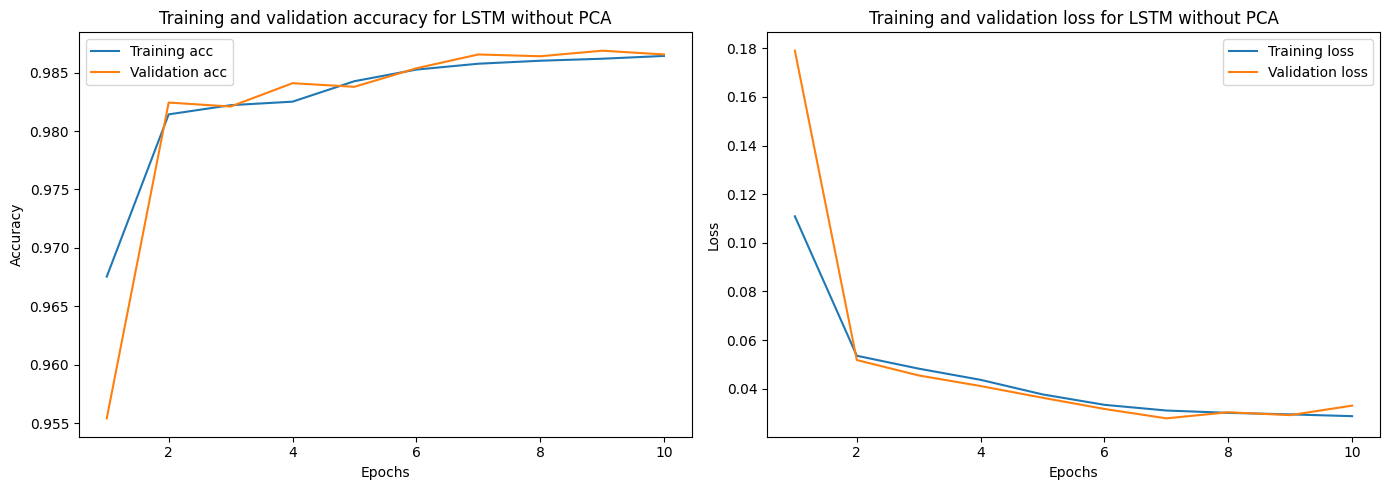

In [22]:
plot_history(hist_lstm, "LSTM without PCA")

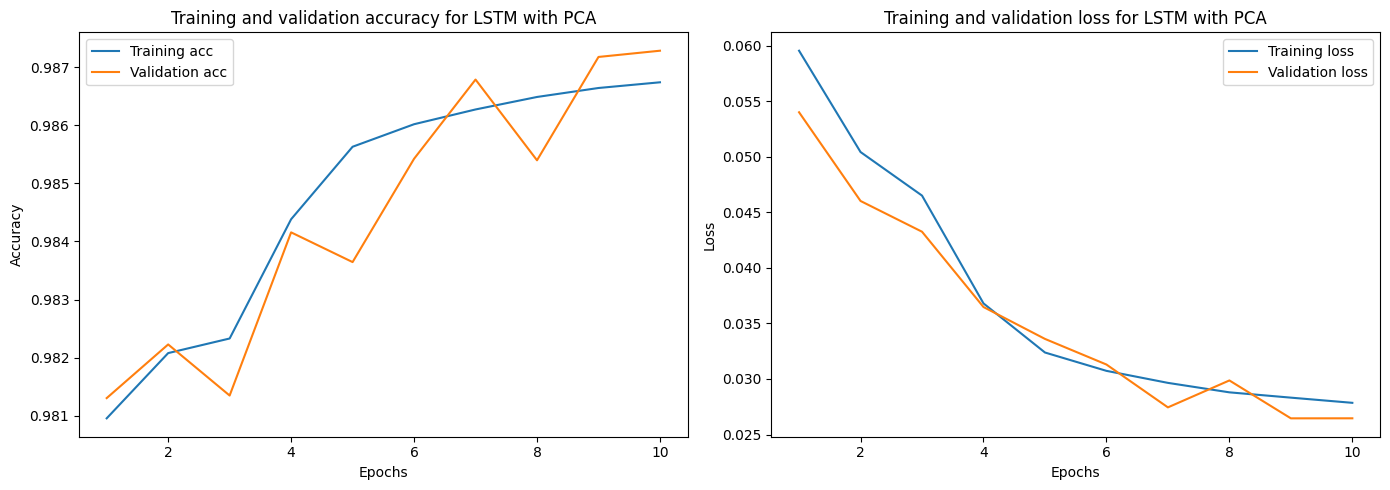

In [19]:
plot_history(hist_lstm_pca, "LSTM with PCA")

In [29]:
# Classification Report with label names
class_dict ={
    'Benign': 0,
    'DDOS attack-HOIC': 4,
    'DoS attacks-Hulk': 7,
    'Bot': 1,
    'FTP-BruteForce': 10,
    'SSH-Bruteforce': 13,
    'Infilteration': 11,  
    'DoS attacks-SlowHTTPTest': 8,
    'DoS attacks-GoldenEye': 6,
    'DoS attacks-Slowloris': 9,
    'DDOS attack-LOIC-UDP': 5,
    'Brute Force -Web': 2,
    'Brute Force -XSS': 3,
    'SQL Injection': 12
}

report_labels_codes = sorted(class_dict.values())
inverse_class_dict = {v: k for k, v in class_dict.items()}
report_target_names = [inverse_class_dict[code] for code in report_labels_codes]
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                           labels=report_labels_codes,      
                           target_names=report_target_names, 
                           zero_division=0,
                           digits=4))


Classification Report:
                          precision    recall  f1-score   support

                  Benign     0.9866    0.9963    0.9914   1216289
                     Bot     0.9996    0.9989    0.9992     56957
        Brute Force -Web     0.7606    0.5047    0.6067       107
        Brute Force -XSS     0.9091    0.4255    0.5797        47
        DDOS attack-HOIC     1.0000    1.0000    1.0000    136973
    DDOS attack-LOIC-UDP     1.0000    0.9939    0.9969       327
   DoS attacks-GoldenEye     0.9994    0.9996    0.9995      8251
        DoS attacks-Hulk     1.0000    1.0000    1.0000     92590
DoS attacks-SlowHTTPTest     1.0000    1.0000    1.0000     27692
   DoS attacks-Slowloris     0.9950    0.9995    0.9973      2195
          FTP-BruteForce     1.0000    1.0000    1.0000     38427
           Infilteration     0.7792    0.4932    0.6040     32103
           SQL Injection     0.8333    0.3125    0.4545        16
          SSH-Bruteforce     1.0000    1.0000    1.

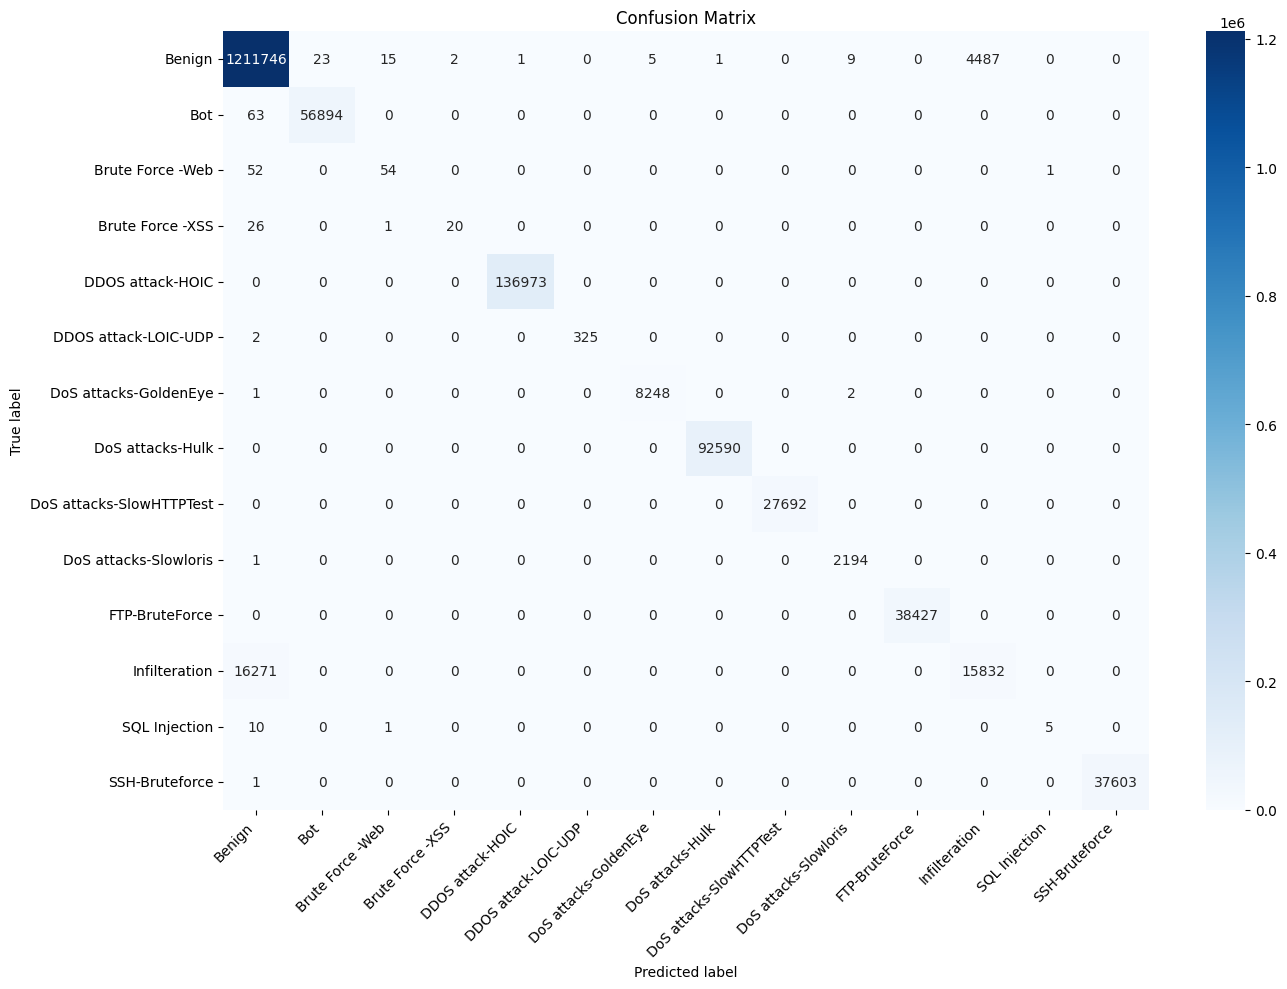

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=report_labels_codes)
plt.figure(figsize=(14,10))

sns.heatmap(cm,
            annot=True,       
            fmt='d',          
            cmap='Blues',     
            xticklabels=report_target_names, 
            yticklabels=report_target_names) 
plt.xticks(rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.show()